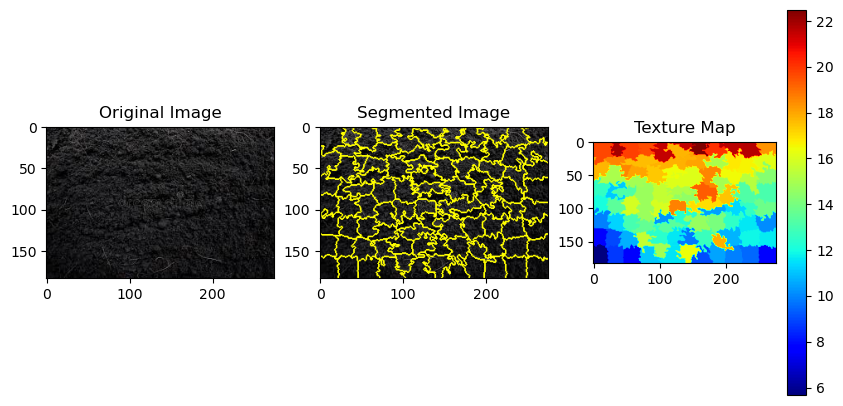

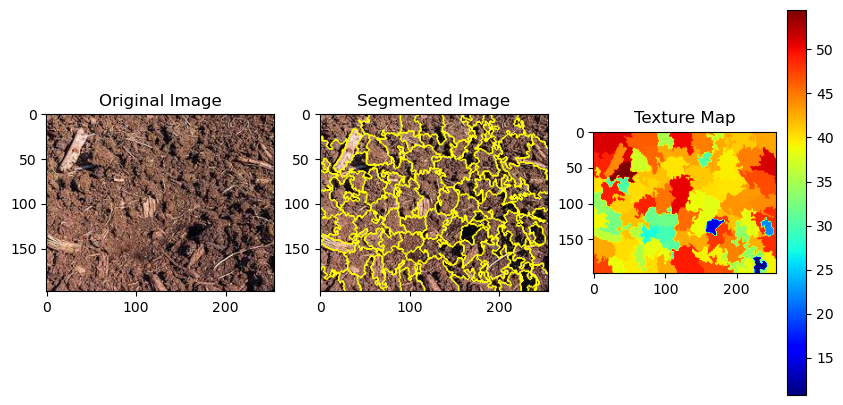

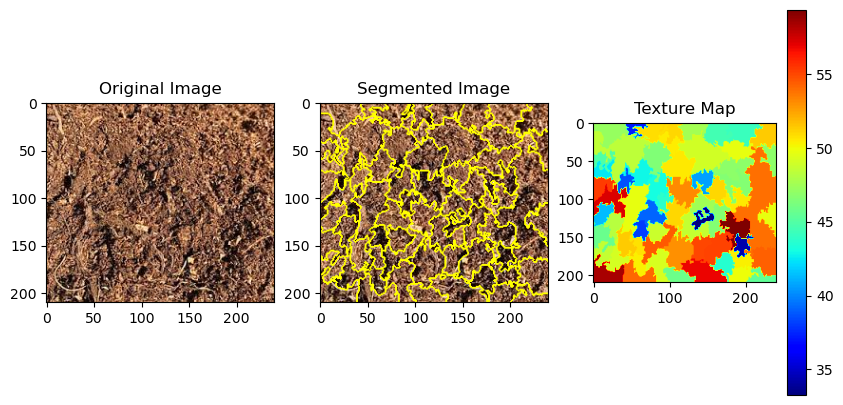

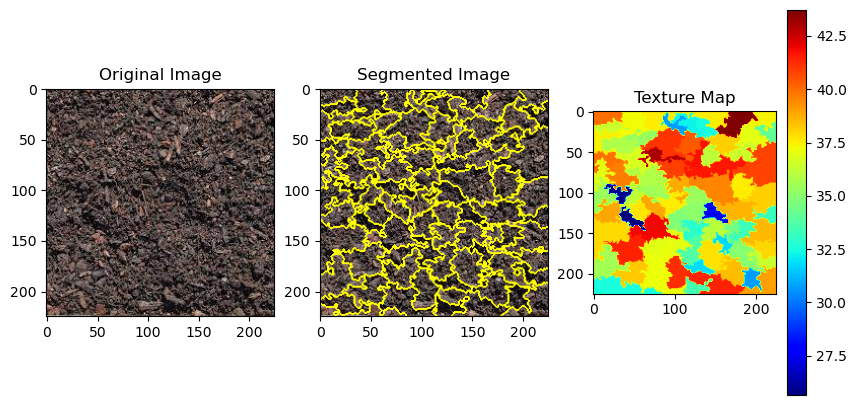

Classified as: Medium Soil


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic, mark_boundaries
from sklearn.preprocessing import StandardScaler
import os

# Create directory for output results
output_dir = "/mnt/data/soil_analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Function to extract features from an image
def extract_soil_features(image_path, n_segments=100):
    """Extracts features from a soil image."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Unable to load the image from {image_path}")
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    segments = slic(img_rgb, n_segments=n_segments, compactness=10, sigma=1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(img_rgb, segments))
    plt.title("Segmented Image")
    
    n_segments = np.max(segments) + 1
    segment_features = []
    texture_img = np.zeros_like(img_rgb[:,:,0], dtype=np.float32)
    
    for i in range(n_segments):
        mask = segments == i
        if np.sum(mask) > 0:
            r_mean = np.mean(img_rgb[:, :, 0][mask])
            g_mean = np.mean(img_rgb[:, :, 1][mask])
            b_mean = np.mean(img_rgb[:, :, 2][mask])
            gray_segment = cv2.cvtColor(img_rgb * np.dstack([mask, mask, mask]), cv2.COLOR_RGB2GRAY)
            std_dev = np.std(gray_segment[gray_segment > 0]) if np.any(gray_segment > 0) else 0
            segment_features.append([r_mean, g_mean, b_mean, std_dev])
            texture_img[mask] = std_dev
    
    plt.subplot(1, 3, 3)
    plt.imshow(texture_img, cmap='jet')
    plt.title("Texture Map")
    plt.colorbar()
    plt.show()
    
    segment_features = np.array(segment_features)
    return np.mean(segment_features, axis=0)

# Load three reference soil samples
sample_paths = ["soil_1.jpg", "soil_2.jpg", "soil_3.jpg"]
sample_features = np.array([extract_soil_features(path) for path in sample_paths])

# Normalize features
scaler = StandardScaler()
normalized_samples = scaler.fit_transform(sample_features)

def classify_soil(image_path):
    """Classifies soil based on extracted features and compares with samples."""
    test_features = extract_soil_features(image_path)
    test_features = scaler.transform([test_features])
    distances = np.linalg.norm(normalized_samples - test_features, axis=1)
    closest_sample = np.argmin(distances)
    
    soil_types = ["Dark Soil (High Organic Matter)", "Medium Soil", "Light Soil (Low Organic Matter)"]
    classified_soil = soil_types[closest_sample]
    
    print(f"Classified as: {classified_soil}")
    return classified_soil

# Test with a new image
image_path = "test_soil3.jpg"
soil_classification = classify_soil(image_path)
